In [2]:
import geopandas
from matplotlib import colors
import matplotlib.pyplot as plt
from descartes import PolygonPatch
import geohash
import numpy as np
import cartopy.crs as ccrs
import pandas as pd
import json

## Parse / Scraping Station data

In [5]:
from tqdm import tqdm
import requests
from bs4 import BeautifulSoup

## Style Reference

In [6]:
### Copied from https://github.com/tkdang97/Cloudy-with-a-Chance-of-Short-RTTs/blob/main/speedchecker-analysis.ipynb
cols = ["#c1d5e2", "#ce9c7f", "#7598b6", "#6a7465", "#914c09", "#663979", "#fbe17b"]

### Defining Categories of things so they have consistent color and linestyle

# Continents
continents = ["AF", "AS", "EU", "NA", "OC", "SA"]
continent_colors = {
        "AF": cols[0],
        "AS": cols[4],
        "EU": cols[1],
        "NA": cols[2],
        "OC": cols[5],
        "SA": cols[3]
    }
lstyles = {
        "AF": "solid",
        "AS": "solid",
        "EU": "dashed",
        "NA": "dotted",
        "OC": "dashdot",
        "SA": "dotted"
    } # Check out parametrized linestyle for more linestyle options

### Scraping Starlink Gateway Data

The site https://satellitemap.space/ hosts a crowd-sourced map of Starlink gateways (among other things). As of 2023-03-09, we can extract the basestations depicted in this website by saving the `basestation.json` file from the network traffics. In the firefox browser, we can copy the `basestation.json` from the network traffix log. Below we display the content of that file.

The `desc`, coordinates `lat`&`lng`, and maybe `town` is the most interesting. It is not clear to me currently, where the `status` attribute comes from.

In [7]:
# Manually written logic to classify basestation sources
def tag_sourcetype(row):
    desc = row["desc"]
    if("fcc.report" in desc
        or "web.acma.gov.au" in desc
        or "rrf.rsm.govt.nz" in desc):
        row["srctype"] = "filing"
    elif("whatdotheyknow.com" in desc
        or "arcep.fr" in desc
        or "legales.elmostrador.cl" in desc
        or "bip.uke.gov.pl" in desc):
        row["srctype"] = "filing2"
    else:
        row["srctype"] = "crowdsourced"
        
# removed from elif: or "t.me" in desc
# We can't really say that the information from the PermessiBot is traceable from
# an official public document because I can't find anything linked in the telegram bot message

In [8]:
with open("data/gsdata/satellitemap_basestations.json", "r") as bs_file:
    basestation_json = json.loads(bs_file.read())

basestations = basestation_json["basestations"]
for b in basestations:
    tag_sourcetype(b)
slgs_df = pd.DataFrame.from_dict(basestations)
slgs_df.rename(columns={'lng':'long'}, inplace=True)
slgs_df

,town,desc,lat,long,cc,fd,td,dg,fdd,tdd,dgd,status,srctype,d,url
0,Conrad MT,Antenna count: 8<br>Antenna diameter: 5 feet<b...,48.203306,-111.945278,US,2019-07-17,2019-11-05,2020-03-04,882.0,771.0,651.0,active,filing,NaN,NaN
1,Loring ME,Antenna count: 8<br>Antenna diameter: 5 feet<b...,46.914917,-67.919528,US,2019-09-24,2020-01-08,,813.0,707.0,0.0,active,filing,NaN,NaN
2,Redmond WA,Antenna count: 8<br>Antenna diameter: 5 feet<b...,47.694194,-122.032139,US,2019-04-05,2019-05-15,2019-05-15,985.0,945.0,945.0,active,filing,NaN,NaN
3,Greenville PA,Antenna count: 8<br>Antenna diameter: 5 feet<b...,41.433556,-80.333222,US,2019-04-05,2019-05-15,2019-05-15,985.0,945.0,945.0,active,filing,NaN,NaN
4,Merrillan WI,"<img src=""https://doc-10-78-mymaps.googleuserc...",44.406333,-90.814278,US,2019-04-05,2019-05-15,2019-05-15,985.0,945.0,945.0,active,filing,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111,"Ibi, Alicante","Feedback received, exact location/status unknown.",38.630700,-0.544700,ES,NaN,NaN,NaN,NaN,NaN,NaN,NaN,crowdsourced,NaN,NaN
112,"Lepe, Huelva","Feedback received, exact location/status unkniwn.",37.257200,-7.203300,ES,NaN,NaN,NaN,NaN,NaN,NaN,NaN,crowdsourced,NaN,NaN
113,Foggia,Approximate. State Road 554. See permessibot t...,41.507306,15.585439,IT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,crowdsourced,NaN,NaN
114,"Petrosino, Marsala",Approximate. See permissibot telegram note htt...,37.711000,12.487900,IT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,crowdsourced,NaN,NaN


In [9]:
slgs_df[slgs_df["town"].str.contains("anchorage", case=False)]

,town,desc,lat,long,cc,fd,td,dg,fdd,tdd,dgd,status,srctype,d,url


In [10]:
# Starlink Availability scraped from wikipedia

from bs4 import BeautifulSoup
import requests

response = requests.get("https://en.wikipedia.org/wiki/Starlink")
soup = BeautifulSoup(response.text)

countries_soup = soup.find_all("table", attrs={"class": "wikitable"})[1]

countries = []
for a in countries_soup.find_all("tr")[1:]:
    for b in a.find_all("td")[2].find_all("a"):
        countries.append(b.text)

> Why scraping from wikipedia and not from the starlink website directly?

To the best of our knowledge, there is no direct way to get access on a list of accessibility of a country. The [website](https://www.starlink.com/map) shows a map of availabilities, but not directly scrapeable list. Api endpoints of [prices.json](https://api.starlink.com/public-files/prices.json) shows prices for each country and api endpoint [coverage_residential.json](https://api.starlink.com/public-files/coverage_residential.json) shows, I'm assuming, polygon data for the map rendering of availabilities. Getting the country name form the polygon data is non-trivial and the prices list do not guarantee that Starlink is in fact available in that country, only that there exists a price out there.

We can also scrape gateway information from https://www.google.com/maps/d/u/0/viewer?mid=1805q6rlePY4WZd8QMOaNe2BqAgFkYBY&ll=-12.088950899999976%2C-76.9731775&z=8

Run this:

```bash
wget "https://www.google.com/maps/d/u/0/kml?mid=1805q6rlePY4WZd8QMOaNe2BqAgFkYBY&forcekml=1" -O Gateways_PoPs_n_Backbone.kml
```

In [82]:
from bs4 import BeautifulSoup

def process_kml(file_path):
    with open(file_path, "r") as f:
        kml_str = f.read()
    soup = BeautifulSoup(kml_str, "xml")
    return soup
        
file_path = "./data/Gateways_PoPs_n_Backbone.kml"
file_path = "./data/Starlink_Global_Gateways_PoPs_Backbone_2023-05-26.kml"

soup = process_kml(file_path)

In [85]:
a = soup.find_all("Folder")

In [98]:
aba, baba = a[2].find_all("Placemark")[0].find("Data", attrs={"name" : "Coords"}).find("value").text.split(",")

In [101]:
gateway_locs = []
for f in soup.find_all("Folder"):
    if(f.find("name").text == "PoPs & Backbone"):
        continue
    continent = f.find("name").text
    for pm in f.find_all("Placemark"):
        gateway_locs.append((continent, pm))

def parse_pm_gw(continent, pm):
    d = {}
    #print("asd", str(pm.find("Data", attrs={"name" : "Coords"}).find("value").text.split(",")))
    try:
        lat, lon = pm.find("Data", attrs={"name" : "Coords"}).find("value").text.split(",")
        lat = float(lat.strip())
        lon = float(lon.strip())
        d["continent"] = continent
        d["lat"] = lat
        d["long"] = lon
    except:
        d["continent"] = continent
        d["lat"] = float("nan")
        d["long"] = float("nan")
    return d
    
gateway_locs = [parse_pm_gw(cont, gl) for (cont, gl) in gateway_locs]
gateway_df = pd.DataFrame(gateway_locs)

In [115]:
pop_df

,lat,long
0,47.614449,-122.338678
1,41.876069,-87.631648
2,39.745663,-104.995712
3,34.047997,-118.255685
4,40.719851,-74.004389
...,...,...
59,-31.864273,115.895867
60,14.564626,121.021875
61,21.705561,-156.917106
62,1.342119,103.949061


In [116]:
pop_locs = []
for f in soup.find_all("Folder"):
    if(f.find("name").text != "PoPs & Backbone"):
        continue
    for pm in f.find_all("Placemark"):
        if(f.find("styleUrl").text != "#icon-1609-0288D1"):
            continue
        #print(pm)
        if(pm == None):
            print(f)
        pop_locs.append(pm)

def parse_pm_pop(pm):
    d = {}
    #print(pm.find("coordinates").text.split(","))
    coordinates = pm.find("coordinates").text.split(",")
    lat = float(coordinates[1].strip())
    lon = float(coordinates[0].strip())
    d["lat"] = lat
    d["long"] = lon
    return d
    
pop_locs = [parse_pm_pop(pl) for pl in pop_locs]
pop_df = pd.DataFrame(pop_locs)

from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="geoapiExercises")

def city_state_country(row):
    coord = f"{row['lat']}, {row['long']}"
    location = geolocator.reverse(coord, exactly_one=True)
    if location == None:
        print("NONE")
        print(row)
        print(coord)
        row["city"] = None
        row["state"] = None
        row["country"] = None
        return row
    address = location.raw['address']
    city = address.get('city', '')
    state = address.get('state', '')
    country = address.get('country', '')
    row['city'] = city
    row['state'] = state
    row['country'] = country
    return row

pop_df = pop_df.apply(city_state_country, axis=1)

NONE
lat      21.705561
long   -156.917106
Name: 61, dtype: float64
21.7055614, -156.917106


In [117]:
pop_df

,lat,long,city,state,country
0,47.614449,-122.338678,Seattle,Washington,United States
1,41.876069,-87.631648,Chicago,Illinois,United States
2,39.745663,-104.995712,Denver,Colorado,United States
3,34.047997,-118.255685,Los Angeles,California,United States
4,40.719851,-74.004389,City of New York,New York,United States
...,...,...,...,...,...
59,-31.864273,115.895867,,Western Australia,Australia
60,14.564626,121.021875,Makati,,Philippines
61,21.705561,-156.917106,NaN,NaN,NaN
62,1.342119,103.949061,Singapore,,Singapore


### Scraping SatNOGS data

In [14]:
# Very rough scraper, does not scraper frequency data which might be interesting at some point

df_dict = {
    "names": [],
    "lat": [],
    "long": [],
    "altitudes_m": [],
    "minelevations_deg": []
}

table_query_str = "https://network.satnogs.org/stations/?testing=0&offline=0&future=0&freq=&page={}"
station_query_str = "https://network.satnogs.org{}"

for i in range(14):
    idx = i+1
    print("Parse page:", idx)
    
    resp = requests.get(query_str.format(idx))
    soup = BeautifulSoup(resp.text)
    gstable = soup.find("table")
    rows = gstable.find_all("tr")
    
    for row in tqdm(rows):
        resp = requests.get(station_query_str.format(row["data-href"]))
        soup = BeautifulSoup(resp.text)

        # Name
        name = soup.find("h2").text.strip()
        df_dict["names"].append(name)

        rowarray = soup.find("tbody").find_all("tr")

        # Coordinates
        coords_str = rowarray[2].find_all("td")[1].text.strip()
        lat_str, lon_str = coords_str.split(",")
        lat = float(lat_str[:-1])
        lon = float(lon_str[:-1])
        df_dict["lat"].append(lat)
        df_dict["long"].append(lon)

        # Altitude in meter
        altitude_m = rowarray[3].find_all("td")[1].text.strip().split(" ")[0]
        df_dict["altitudes_m"].append(altitude_m)

        # Min Elevation in deg
        minelevation_deg = rowarray[4].find_all("td")[1].text.strip().split("°")[0]
        df_dict["minelevations_deg"].append(minelevation_deg)

df = pd.DataFrame(df_dict)
df

Parse page: 1


NameError: name 'query_str' is not defined

In [15]:
df.to_csv("data/gsdata/gsdata_satnog.csv")

NameError: name 'df' is not defined

## Plotting GSaaS Map

In [16]:
# https://network.satnogs.org/stations/
# Scraped, see code above
gsdata_satnog = pd.read_csv("data/gsdata/gsdata_satnog.csv")

# https://www.ksat.no/ground-network-services/the-ksat-global-ground-station-network/
# Accessed: 2023-03-08
gsdata_ksat   = pd.read_csv("data/gsdata/gsdata_ksat.csv")

# https://atlasground.com/wp-content/uploads/2022/12/WEB-120522-Antenna-Network-Map.pdf
# Accessed: 2023-03-09
gsdata_atlas  = pd.read_csv("data/gsdata/gsdata_atlas.csv")

# https://leaf.space/
# Accessed: 2023-03-09
gsdata_leaf   = pd.read_csv("data/gsdata/gsdata_leaf.csv")

# Azure
# https://azure.microsoft.com/en-us/products/orbital/

In [17]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,889953.0,Oceania,Fiji,FJI,5496,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,58005463.0,Africa,Tanzania,TZA,63177,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253.0,Africa,W. Sahara,ESH,907,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,37589262.0,North America,Canada,CAN,1736425,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,328239523.0,North America,United States of America,USA,21433226,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."
...,...,...,...,...,...,...
172,6944975.0,Europe,Serbia,SRB,51475,"POLYGON ((18.82982 45.90887, 18.82984 45.90888..."
173,622137.0,Europe,Montenegro,MNE,5542,"POLYGON ((20.07070 42.58863, 19.80161 42.50009..."
174,1794248.0,Europe,Kosovo,-99,7926,"POLYGON ((20.59025 41.85541, 20.52295 42.21787..."
175,1394973.0,North America,Trinidad and Tobago,TTO,24269,"POLYGON ((-61.68000 10.76000, -61.10500 10.890..."


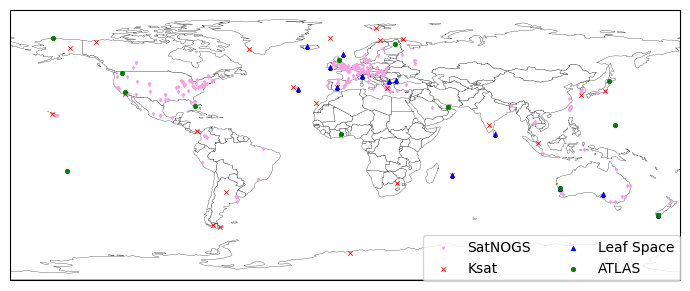

In [18]:
continents = ["AF", "AS", "EU", "NA", "OC", "SA"]
cols = ["#c1d5e2", "#ce9c7f", "#7598b6", "#6a7465", "#914c09", "#663979", "#fbe17b"]

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
#world = world[(world.name!="Antarctica")]

fig, ax = plt.subplots(figsize=(7, 3), subplot_kw={'projection': ccrs.PlateCarree()})

cmap = colors.ListedColormap(cols[:-2])
world.plot(facecolor = "white", edgecolor="black", ax=ax, linewidth=0.2)

# Plotting GS points
def plot_gsdata(gsdata_df, ax, label, marker, color, size=10):
    latitude, longitude = gsdata_df["lat"], gsdata_df["long"]
    ax.scatter(longitude, latitude,
               sizes = [size],
               color=color,
               zorder = 10,
               marker=marker,
               linewidth = 0.6,
               label=label)

plot_gsdata(gsdata_satnog, ax, "SatNOGS", "v", "#f7a1e2", 4)
plot_gsdata(gsdata_ksat, ax, "Ksat", "x", "red")
plot_gsdata(gsdata_leaf, ax, "Leaf Space", "^", "blue")
plot_gsdata(gsdata_atlas, ax, "ATLAS", "o", "green")

    
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])

#plt.legend(loc = "lower left")
#lt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1),
#         ncol=4, fancybox=True, shadow=False)
plt.legend(loc='lower right', bbox_to_anchor=(1.01, -0.03),
          ncol=2, fancybox=True, shadow=False)

plt.axis('tight')
plt.tight_layout()
#plt.axis('tight')
plt.savefig("figures/gs_services.pdf", pad_inches=0)
plt.show()

## Plotting Starlink Gateway Map

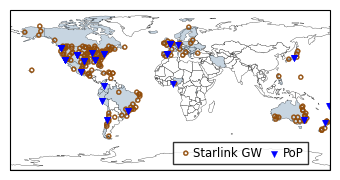

In [26]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
#world = world[(world.name!="Antarctica")]

fig, ax = plt.subplots(figsize=(3.5, 1.9), subplot_kw={'projection': ccrs.PlateCarree()})

cmap = colors.ListedColormap(cols[:-2])
world.plot(facecolor = "white", edgecolor="black", ax=ax, linewidth=0.2)

# Plot Country Patches where a Starlink is available
def plotCountryPatch( axes, country_name, fcolor ):
    # plot a country on the provided axes
    nami = world[world.name == country_name]
    namigm = nami.__geo_interface__['features']  # geopandas's geo_interface
    namig0 = {'type': namigm[0]['geometry']['type'], \
              'coordinates': namigm[0]['geometry']['coordinates']}
    axes.add_patch(PolygonPatch( namig0, fc=fcolor, ec="black", alpha=0.4, zorder=2, linewidth=0.0 ))
for c in countries:
    c = "United States of America" if c == "United States" else c
    
    if(c in world["name"].values):
        plotCountryPatch(ax, c, cols[2])

# Plotting GS points
def plot_gsdata(gsdata_df, ax, label, marker, color, size=10, lw=0.6):
    latitude, longitude = gsdata_df["lat"], gsdata_df["long"]
    ax.scatter(longitude, latitude,
               sizes = [size],
               color=color,
               zorder = 10,
               marker=marker,
               linewidth = lw,
               label=label)
 

plot_gsdata(gateway_df, ax, "Starlink GW", "$\circ$", cols[4], 30, lw=0.3)
plot_gsdata(pop_df, ax, "PoP", "v", "blue", 20, lw=0.3)
#plot_gsdata(slgs_df[(slgs_df["srctype"] == "filing") | (slgs_df["srctype"] == "filing2")],
#            ax, "traceable to official public document", "x", "red", size=2)
#plot_gsdata(slgs_df[slgs_df["srctype"] == "filing2"],
#            ax, "Ksat", "x", "blue", size=2)
#plot_gsdata(slgs_df[slgs_df["srctype"] == "crowdsourced"],
#            ax, "crowdsourced", "o", "green", size=2)
#plot_gsdata(gsdata_leaf, ax, "Leaf Space", "^", "blue")
#plot_gsdata(gsdata_atlas, ax, "ATLAS", "o", "green")
    
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])

#plt.legend(loc = "lower left")
#plt.legend(loc='lower right', bbox_to_anchor=(1.01, -0.03),
#          ncol=2, fancybox=True, shadow=False)
ax.legend(loc="lower right", fontsize="small", ncol=2, edgecolor="k", handlelength=1, labelspacing=0.06,
          columnspacing=0.5, bbox_to_anchor=(0.95, 0.0), handletextpad=0.3, fancybox=False)

plt.axis('tight')
plt.tight_layout()
plt.savefig("figures/map_starlink_gws.pdf", bbox_inches="tight", pad_inches=0)
plt.savefig("figures/map_starlink_gws.svg", bbox_inches="tight", pad_inches=0)
plt.show()

In [49]:
exp_df = pd.read_csv("data/eu_p75_minrtt.csv")
exp_df = exp_df.rename(columns={'latitude': 'lat', 'longitude': 'long'})

In [65]:
exp_df

,client_Geo_City,lat,long,p75_minRTT
0,Warsaw,52.229854,21.006645,63.51850
1,Athens,37.984200,23.735300,95.95650
2,Paris,48.832300,2.407500,63.46200
3,Prague,50.084994,14.449950,52.06400
4,Sofia,42.695100,23.325000,88.11350
5,Vienna,48.203210,16.367157,54.22000
6,Ljubljana,46.051630,14.512865,66.24400
7,Chisinau,47.004200,28.857400,81.90400
8,Brussels,50.851493,4.345823,52.87550
9,Kyiv,50.458000,30.530300,76.45475


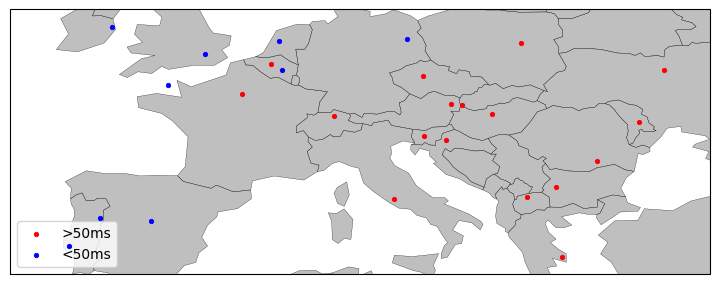

In [64]:
continents = ["AF", "AS", "EU", "NA", "OC", "SA"]
cols = ["#c1d5e2", "#ce9c7f", "#7598b6", "#6a7465", "#914c09", "#663979", "#fbe17b"]

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

fig, ax = plt.subplots(figsize=(7, 3), subplot_kw={'projection': ccrs.PlateCarree()})

ax.set_xlim([-180, 180])
ax.set_ylim([-90, 90])

# Plot Country
cmap = colors.ListedColormap(cols[:-2])
world.plot(facecolor = "#88888888", edgecolor="black", ax=ax, linewidth=0.2)

# Plot US Regions and Starlink Gateways
plotCountryPatch(ax, "United States of America", cols[2])
#plot_gsdata(slgs_df[(slgs_df["cc"] == "US")],
#            ax, "Gateways", "x", "red", size=10)

plot_gsdata(exp_df[exp_df["p75_minRTT"] > 50],
            ax, ">50ms", "o", "red", size=10)

plot_gsdata(exp_df[exp_df["p75_minRTT"] < 50],
            ax, "<50ms", "o", "blue", size=10)

# Plot cities
#df_cities = pd.read_csv("data/mlab_starlink_data/ndt7_cities_overview.csv")
#us_cities = df_cities[df_cities["ClientCountry"] == "United States"].copy()
#ghlist = us_cities["ClientGeohash"]
#us_cities["lat"]  = us_cities["ClientGeohash"].apply(lambda gh: geohash.decode(gh)[0])
#us_cities["long"] = us_cities["ClientGeohash"].apply(lambda gh: geohash.decode(gh)[1])
#plot_gsdata(us_cities,
#            ax, "", "o", "blue", size=3)
#for x, y, label in zip(us_cities["long"], us_cities["lat"], us_cities["ClientCity"]):
#    interesting_us_cities = [
#        "Seattle", "Denver", "Dallas", "Los Angeles", "New York"
#    ]
#    if(not label in interesting_us_cities):
#        continue
#    ax.annotate(label, xy=(x, y), xytext=(2, 2), textcoords="offset points")

plt.legend(loc = "lower left")
#plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1),
#          ncol=4, fancybox=True, shadow=True)
#ax.set_axis_off()
ax.set_ylim((36.87435897635284, 54.518971419474546))
ax.set_xlim((-13.071185447888354, 33.62153528603861))

#plt.axis('tight')
plt.tight_layout(pad=0)
#plt.savefig("figures/starlink_gws_US.pdf", pad_inches=0, bbox_inches='tight')
plt.show()

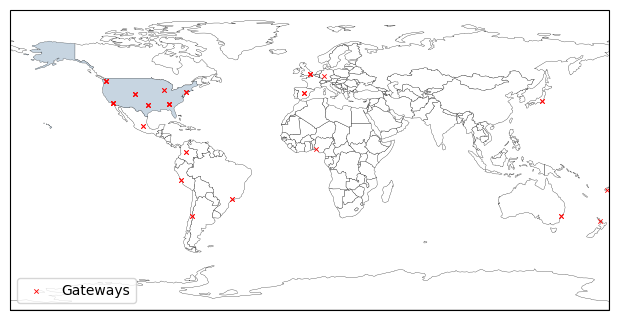

In [20]:
continents = ["AF", "AS", "EU", "NA", "OC", "SA"]
cols = ["#c1d5e2", "#ce9c7f", "#7598b6", "#6a7465", "#914c09", "#663979", "#fbe17b"]

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

fig, ax = plt.subplots(figsize=(7, 3), subplot_kw={'projection': ccrs.PlateCarree()})

ax.set_xlim([-180, 180])
ax.set_ylim([-90, 90])

# Plot Country
cmap = colors.ListedColormap(cols[:-2])
world.plot(facecolor = "white", edgecolor="black", ax=ax, linewidth=0.2)

# Plot US Regions and Starlink Gateways
plotCountryPatch(ax, "United States of America", cols[2])
#plot_gsdata(slgs_df[(slgs_df["cc"] == "US")],
#            ax, "Gateways", "x", "red", size=10)

plot_gsdata(pop_df,
            ax, "Gateways", "x", "red", size=10)

# Plot cities
#df_cities = pd.read_csv("data/mlab_starlink_data/ndt7_cities_overview.csv")
#us_cities = df_cities[df_cities["ClientCountry"] == "United States"].copy()
#ghlist = us_cities["ClientGeohash"]
#us_cities["lat"]  = us_cities["ClientGeohash"].apply(lambda gh: geohash.decode(gh)[0])
#us_cities["long"] = us_cities["ClientGeohash"].apply(lambda gh: geohash.decode(gh)[1])
#plot_gsdata(us_cities,
#            ax, "", "o", "blue", size=3)
#for x, y, label in zip(us_cities["long"], us_cities["lat"], us_cities["ClientCity"]):
#    interesting_us_cities = [
#        "Seattle", "Denver", "Dallas", "Los Angeles", "New York"
#    ]
#    if(not label in interesting_us_cities):
#        continue
#    ax.annotate(label, xy=(x, y), xytext=(2, 2), textcoords="offset points")

plt.legend(loc = "lower left")
#plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1),
#          ncol=4, fancybox=True, shadow=True)
#ax.set_axis_off()

#plt.axis('tight')
plt.tight_layout(pad=0)
#plt.savefig("figures/starlink_gws_US.pdf", pad_inches=0, bbox_inches='tight')
plt.show()

In [27]:
slrank_df = pd.read_csv("data/mlab_country_starlinkrank.csv", sep="\t")

,CountryName,MeasurementCount,TestSpanDays,AvgLongitude,AvgLatitude,Rank
0,Saint Barthélemy,1613,208,-62.850000,17.883300,2
1,Saint Martin,903,189,-63.087312,18.072693,3
2,Tonga,18,14,-175.203200,-21.147400,3
3,Dominican Republic,6891,210,-69.892287,18.462932,3
4,U.S. Virgin Islands,1845,209,-64.931900,18.338200,3
...,...,...,...,...,...,...
61,Bulgaria,67,203,23.325000,42.695100,82
62,Sweden,745,206,18.071700,59.328700,88
63,Kenya,12,13,36.815500,-1.284100,131
64,Switzerland,18,181,8.567100,47.368200,175


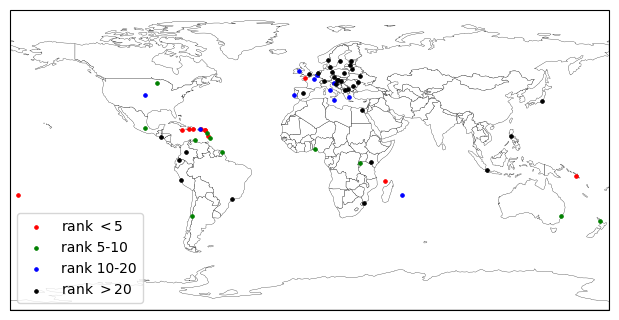

In [43]:
continents = ["AF", "AS", "EU", "NA", "OC", "SA"]
cols = ["#c1d5e2", "#ce9c7f", "#7598b6", "#6a7465", "#914c09", "#663979", "#fbe17b"]



world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

fig, ax = plt.subplots(figsize=(7, 3), subplot_kw={'projection': ccrs.PlateCarree()})

ax.set_xlim([-180, 180])
ax.set_ylim([-90, 90])

# Plot Country
cmap = colors.ListedColormap(cols[:-2])
world.plot(facecolor = "white", edgecolor="black", ax=ax, linewidth=0.2)

temp_df = slrank_df[(slrank_df["Rank"] < 6)]
longitude, latitude = temp_df["AvgLongitude"], temp_df["AvgLatitude"]
ax.scatter(longitude, latitude,
               sizes = [30],
               color="r",
               zorder = 10,
               marker=".",
               linewidth = 0.5,
               label="rank $<$5")

temp_df = slrank_df[(slrank_df["Rank"] > 5) & (slrank_df["Rank"] < 11)]
longitude, latitude = temp_df["AvgLongitude"], temp_df["AvgLatitude"]
ax.scatter(longitude, latitude,
               sizes = [30],
               color="g",
               zorder = 10,
               marker=".",
               linewidth = 0.5,
               label="rank 5-10")

temp_df = slrank_df[(slrank_df["Rank"] > 10) & (slrank_df["Rank"] < 21)]
longitude, latitude = temp_df["AvgLongitude"], temp_df["AvgLatitude"]
ax.scatter(longitude, latitude,
               sizes = [30],
               color="b",
               zorder = 10,
               marker=".",
               linewidth = 0.5,
               label="rank 10-20")

temp_df = slrank_df[(slrank_df["Rank"] > 20)]
longitude, latitude = temp_df["AvgLongitude"], temp_df["AvgLatitude"]
ax.scatter(longitude, latitude,
               sizes = [30],
               color="black",
               zorder = 10,
               marker=".",
               linewidth = 0.5,
               label="rank $>$20")

plt.legend(loc = "lower left")
#plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1),
#          ncol=4, fancybox=True, shadow=True)
#ax.set_axis_off()

#plt.axis('tight')
plt.tight_layout(pad=0)
#plt.savefig("figures/starlink_gws_US.pdf", pad_inches=0, bbox_inches='tight')
plt.show()

In [44]:
slrank_df[(slrank_df["Rank"] < 6)]

,CountryName,MeasurementCount,TestSpanDays,AvgLongitude,AvgLatitude,Rank
0,Saint Barthélemy,1613,208,-62.850000,17.883300,2
1,Saint Martin,903,189,-63.087312,18.072693,3
2,Tonga,18,14,-175.203200,-21.147400,3
3,Dominican Republic,6891,210,-69.892287,18.462932,3
4,U.S. Virgin Islands,1845,209,-64.931900,18.338200,3
5,Haiti,145,33,-72.336200,18.541300,4
6,Guernsey,39,72,-2.534108,49.457969,4
7,Martinique,3969,201,-61.072582,14.607077,5
8,Solomon Islands,2,0,159.949400,-9.427700,5
9,Mayotte,73,94,45.166700,-12.833300,5


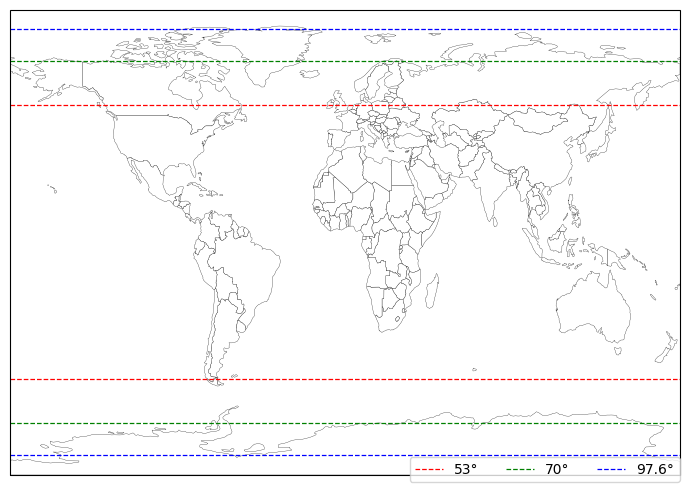

In [21]:
continents = ["AF", "AS", "EU", "NA", "OC", "SA"]
cols = ["#c1d5e2", "#ce9c7f", "#7598b6", "#6a7465", "#914c09", "#663979", "#fbe17b"]

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
#world = world[(world.name!="Antarctica")]

fig, ax = plt.subplots(figsize=(7, 5), subplot_kw={'projection': ccrs.PlateCarree()})

world.plot(facecolor = "white", edgecolor="black", ax=ax, linewidth=0.2)
    
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])

def plot_extent(inclination, color="r", lw=0.9):
    label = "{}°".format(inclination)
    if inclination > 90:
        inclination = 90 - (inclination % 90)
    plt.plot([-180, 180], [ inclination,  inclination], linewidth=lw, color=color, linestyle="dashed", label=label)
    plt.plot([-180, 180], [-inclination, -inclination], linewidth=lw, color=color, linestyle="dashed")

plot_extent(53, "r")
plot_extent(70, "g")
plot_extent(97.6, "b")
    
#plt.legend(loc = "lower left")
plt.legend(loc='lower right', bbox_to_anchor=(1.01, -0.03),
          ncol=3, fancybox=True, shadow=False)

plt.axis('tight')
plt.tight_layout()
plt.savefig("temp.png", pad_inches=0)
plt.show()